great tutorial:
    https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial
        

In [1]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import spacy  # For preprocessing


import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

# user_id to screen_name conversion

In [3]:
ud_df = pd.read_pickle('users_with_over_200_DETAILS.pkl')

In [4]:
def id_to_name(uid):
    return ud_df[ud_df['user_id']==uid]['screen_name'].to_string(index=False).strip()
    
def name_to_id(name):
    uid = ud_df[ud_df['screen_name']==name]['user_id'].to_string(index=False)
    return uid.strip()

In [5]:
name_to_id('Starbucks')

'30973'

In [6]:
ud_df[ud_df['user_id']=='30973']['screen_name'].to_string(index=False)

' Starbucks'

# Read train data

In [2]:
train_data = pd.read_pickle('train_data.pkl')

In [17]:
import random
random.shuffle(train_data[0])

In [30]:
len(train_data)

12101

In [35]:
df_clean = pd.DataFrame([' '.join(map(str, line)) for line in train_data] )

In [36]:
df_clean.shape

(12101, 1)

# Create permutations of the followed users

In [42]:
number_of_shuffles = 5

for _ in range(number_of_shuffles):
    for line in train_data:
        random.shuffle(line)
    shuffled_train_df = pd.DataFrame([' '.join(map(str, line)) for line in train_data] )
    df_clean = df_clean.append(shuffled_train_df)
    
print( "augemented train data length: " , df_clean.shape)

augemented train data length:  (72606, 1)


In [53]:
df_clean.rename(columns={0:'clean'}, inplace=True)

In [54]:
df_clean.head(5)

,clean
0,25073877 469903716 3017670582 133682123 291427...
1,467498446 833167063 31317590 340970049 3331778...
2,548845715 19256962 360731302 73454182 73792770...
3,174533632 51404605 155705264 46769281 51742969...
4,30925378 4276531 2612267718 22442930 268645956...


### Bigrams - not needed for item2vec

In [55]:
from gensim.models.phrases import Phrases, Phraser
sent = [row.split() for row in df_clean['clean']]
phrases = Phrases(sent, min_count=30, threshold =10000 ,progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]

In [56]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

473888

In [57]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['813286',
 '15846407',
 '25073877',
 '15485441',
 '25365536',
 '17919972',
 '27195114',
 '1536791610',
 '27260086',
 '169686021']

## Train the model

In [58]:
import multiprocessing

from gensim.models import Word2Vec

In [59]:
cores = multiprocessing.cpu_count()
cores

24

In [60]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

### Build the vocabolary table

In [61]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 1.06 mins


### Train the model

In [62]:
w2v_model.corpus_count

72606

In [ ]:
time to train 72606 items: 35.25 mins

In [63]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 35.25 mins


### Compacting the model - only if not going to train it further

In [20]:
#w2v_model.init_sims(replace=True)

INFO - 22:38:36: precomputing L2-norms of word weight vectors


### save the model for later usage

In [64]:
w2v_model.save("word2vec_v2.model")

In [65]:
w2v_model.wv.most_similar(positive=["180505807"])

[('17919972', 0.4177761673927307),
 ('25365536', 0.4054202437400818),
 ('26565946', 0.40205350518226624),
 ('35787166', 0.3844498097896576),
 ('813286', 0.3764728307723999),
 ('15846407', 0.37616056203842163),
 ('21818737', 0.37266457080841064),
 ('32959253', 0.3685052990913391),
 ('29840295', 0.3653584420681),
 ('27195114', 0.36493581533432007)]

## t-SNE visualization

In [66]:
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [67]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    #my part -- foo = [a + 42 for a in foo]

    word_labels = [ud_df[ud_df['user_id']==wrd]['screen_name'].to_string(index=False) for wrd in word_labels]
    
    
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    # was:  reduc = PCA(n_components=50).fit_transform(arrays)
    reduc = PCA(n_components=20).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

### 10 Most similar words vs. 10 Most dissimilar

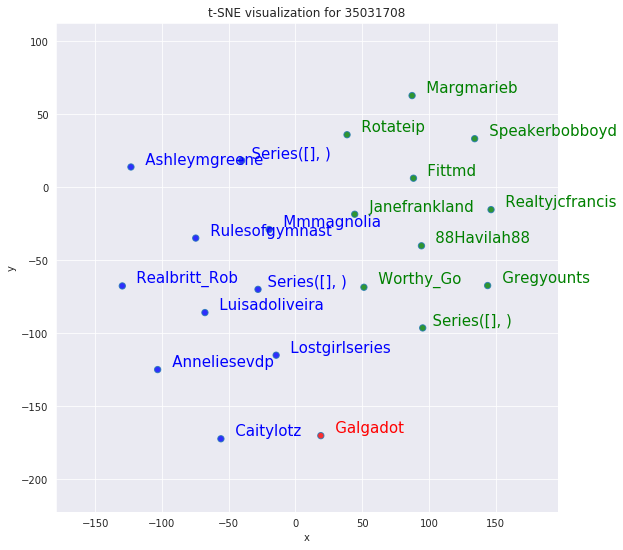

In [81]:
def ten_most_similar(wrd):
    uid = name_to_id(wrd)
    #uid = ud_df[ud_df['screen_name']==wrd]['user_id'].to_string(index=False)
    #uid = uid.strip()
    tsnescatterplot(w2v_model, uid, [i[0] for i in w2v_model.wv.most_similar(negative=[uid])])

ten_most_similar('GalGadot')


Harvard
Target
CNN
Apple
BarackObama
united
ABC
ArianaGrande
NYGovCuomo
KimKardashian
Starbucks


check these ids:
    25073877 => @realDonaldTrump
180505807 => @instagram
25365536 => @KimKardashian
79293791 => @rihanna
28603812 => @Royals

@billgates => 50393960
@cnn => 759251

In [ ]:
tsnescatterplot(w2v_model, '759251', [i[0] for i in w2v_model.wv.most_similar(negative=["759251"])])

# Load from drive

In [2]:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec

In [3]:
model = Word2Vec.load("word2vec_v1.model")